In [2]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical
import os 
import pyupbit
from keras import backend as K

In [3]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [4]:
lstm_model = load_model('LSTM6_epoch_009_val_0.0501332581_mae_0.0351324603_mse_0.0030525343.h5', custom_objects={'Time2Vector':Time2Vector, 'rmse':rmse}) 

lstm_model.summary() 

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 20, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 20, 2)        80          input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 20, 7)        0           input_6[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 20, 128)      69632       concatenate_4[0][0]        

In [5]:
def normalization(df): 
    full_segment = np.copy(df[:,:]) 
    minval = np.min(full_segment[:,:4]) 
    maxval = np.max(full_segment[:,:4]) 
    if maxval != 0: 
        full_segment[:,:4] = (full_segment[:,:4] - minval) / (maxval - minval) 
            
    minval = np.min(full_segment[:,4]) 
    maxval = np.max(full_segment[:,4]) 
    if maxval != 0: 
        full_segment[:,4] = (full_segment[:,4] - minval) / (maxval - minval)
        
    return full_segment[-1,3], full_segment[-20:,:5] 


In [6]:
## setup access and secret keys
access_key = "ZcG39GRdKaD1jPWS9uk4xZxxWtSAlA92yox1xm5A"
secret_key = "Y4I2SCa0HwGfLKxG2MtuZfiyCKlHaW2M3ljOm7Vs"

upbit = pyupbit.Upbit(access_key, secret_key)

In [18]:
# get all tickers 
tickers = pyupbit.get_tickers(fiat="KRW") 
tickers = np.asarray(tickers)
# commissions 
gamma = 0.05

# number of assets in portfolio 
# this time we try with investing into a single asset 
p = 1 

cash_amounts = [] 

# run for as much as we want 
while True: 
    diffs = [] 
    
    print("LSTM making predictions...")
    for ticker in tqdm(tickers): 
        df = pyupbit.get_ohlcv(ticker, interval="minute60") 
        df = df.values 
        curval, inputs = normalization(df) 
        inputs = inputs.reshape((-1,20,5))
        pred = lstm_model.predict(inputs)[0][0] 
        diff = pred-curval
        diffs.append(diff)
        time.sleep(0.1) # for stable API calls
    
    diffs = np.asarray(diffs)    
    idx = diffs.argsort()[-p:][::-1]
    
    max_diffs = diffs[idx] # top p maximum change in descending order 
    chosen_coins = tickers[idx]
    
    invest = True 
    
    if max_diffs[0] > 0: 
        cash_amount = upbit.get_balance("KRW")
        cash_amount = float(cash_amount) 
        cash_amounts.append(cash_amount) 
        print("current cash amount = {}".format(cash_amount)) 
        print("opening positions")
        for i in range(p):
            print("predicted increase = {}, investing in {}...".format(max_diffs[i], chosen_coins[i]))
            upbit.buy_market_order(chosen_coins[i], cash_amount * (1-gamma/100) * (1/p))  
    
    elif max_diffs[0] <= 0: 
        print("a pretty bad down market. We will not invest for this round.")
        invest = False 
    
    print("waiting for an hour")
    time.sleep(60*60) 
    if invest == True: 
        print("closing positions")
        for i in range(p): 
            print("closing position for {}".format(chosen_coins[i]))
            unit = upbit.get_balance(chosen_coins[i])
            upbit.sell_market_order(chosen_coins[i], unit)

  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:28<00:00,  3.58it/s]


current cash amount = 50000.21169683
opening positions
predicted increase = 0.05362518339985256, investing in KRW-GAS...
waiting for an hour
closing positions
closing position for KRW-GAS


  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:28<00:00,  3.62it/s]


current cash amount = 50451.56172503
opening positions
predicted increase = 0.037035697638386766, investing in KRW-IOST...
waiting for an hour
closing positions
closing position for KRW-IOST


  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:28<00:00,  3.57it/s]


current cash amount = 50401.13538913
opening positions
predicted increase = 0.041358057898704614, investing in KRW-IOST...
waiting for an hour
closing positions
closing position for KRW-IOST


  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:39<00:00,  2.58it/s]


current cash amount = 49885.98332972
opening positions
predicted increase = 0.0417594248921771, investing in KRW-GAS...
waiting for an hour
closing positions
closing position for KRW-GAS


  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:32<00:00,  3.09it/s]


current cash amount = 49333.65005632
opening positions
predicted increase = 0.11729857361947504, investing in KRW-GAS...
waiting for an hour
closing positions
closing position for KRW-GAS


  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:34<00:00,  2.97it/s]


current cash amount = 50148.9784185
opening positions
predicted increase = 0.2727398844326243, investing in KRW-HIVE...
waiting for an hour
closing positions
closing position for KRW-HIVE


  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:34<00:00,  2.96it/s]


current cash amount = 50764.30402811
opening positions
predicted increase = 0.04455430131209526, investing in KRW-ZRX...
waiting for an hour
closing positions
closing position for KRW-ZRX


  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:34<00:00,  2.96it/s]


current cash amount = 50485.12568136
opening positions
predicted increase = 0.09964182312132541, investing in KRW-STRK...
waiting for an hour
closing positions
closing position for KRW-STRK


  0%|          | 0/102 [00:00<?, ?it/s]

LSTM making predictions...


100%|██████████| 102/102 [00:35<00:00,  2.91it/s]


current cash amount = 50516.3413496
opening positions
predicted increase = 0.07504200208477863, investing in KRW-MBL...
waiting for an hour


KeyboardInterrupt: 

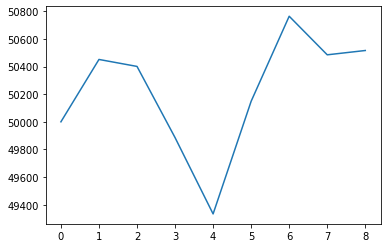

In [19]:
plt.plot(cash_amounts)

Things to fix 

- First, prediction has to be made first 
- Second, the buy and sell process has to be more efficient. 